In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import visualization
import datahandler

In [2]:
participant_code = 'C1K4L9S8'
load_state_data = False
data_path = './participant data/'
trimmed_data, sections = datahandler.load_participant(participant_code, data_path, load_state_data)

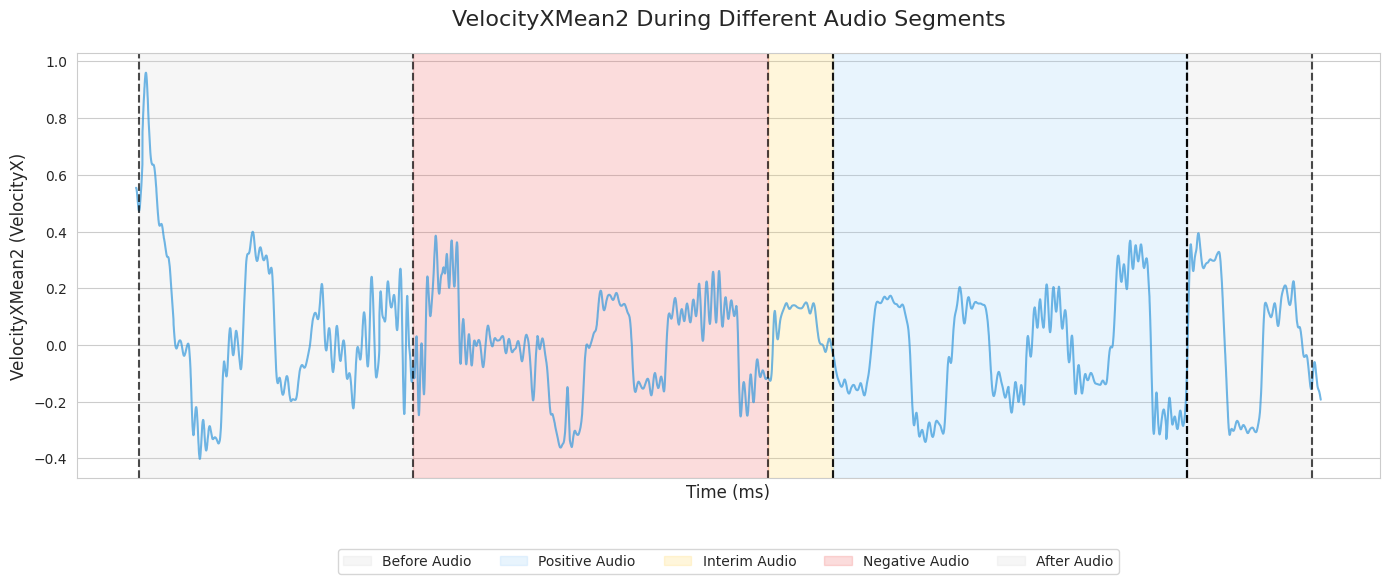

In [3]:
trimmed_data['VelocityXMean2'] = trimmed_data['VelocityX'].rolling(window=10000, min_periods=1000).mean()

visualization.plot_column(trimmed_data, 'VelocityXMean2', 'VelocityX', sections=sections)


In [4]:

  # def cohen_d(x, y):
  #   nx, ny = len(x), len(y)
  #   pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 +
  #                         (ny - 1) * np.std(y, ddof=1)**2) / (nx + ny - 2))
  #   return (np.mean(x) - np.mean(y)) / pooled_std




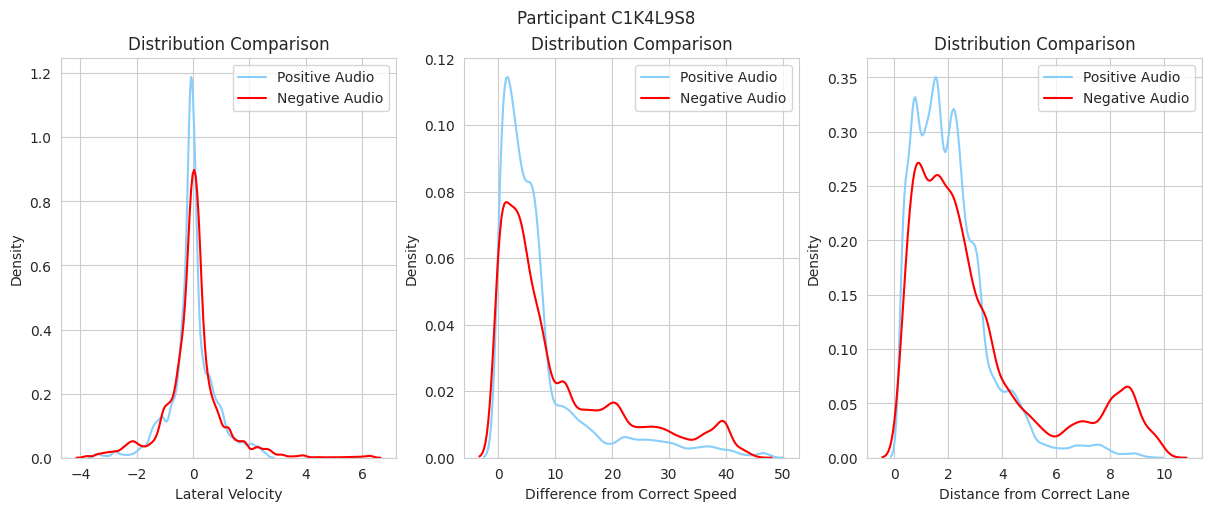

In [6]:
_ = visualization.compare_perf_kdes(participant_code, trimmed_data, sections=sections)


### Analyze distributions

In [33]:
import scipy as scp
def get_statistics(data, column='DistanceToTargetPosition',
                      xlabel='Distance to Correct Lane'):

 
  calm_range = np.arange(calm_audio_start['Timestamp'],
                         calm_audio_end['Timestamp'])
  intense_range = np.arange(intense_audio_start['Timestamp'],
                            intense_audio_end['Timestamp'])

  start1, end1 = calm_range[0], calm_range[-1]
  start2, end2 = intense_range[0], intense_range[-1]

  segment1 = data[(data['Timestamp'] > start1) &
                          (data['Timestamp'] < end1)][column].dropna()
  segment2 = data[(data['Timestamp'] > start2) &
                          (data['Timestamp'] < end2)][column].dropna()
#   print(segment1)

  return np.mean(segment1), np.std(segment1), scp.stats.moment(segment1, order=3, center=True),  np.mean(segment2), np.std(segment2), scp.stats.moment(segment2, order=3, center=True)

In [34]:
get_statistics(data)

(np.float64(1.684268080289983),
 np.float64(0.8609998670641904),
 np.float64(1.9794868024844512),
 np.float64(1.6805303700630867),
 np.float64(0.9354049197850167),
 np.float64(2.849995815938939))

/tmp/ipykernel_15535/3395311658.py:12: DtypeWarning: Columns (3,4,6,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{data_path}{id}.csv', comment='#')
/tmp/ipykernel_15535/3395311658.py:32: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_data = data.interpolate('pad')
/tmp/ipykernel_15535/3395311658.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
/tmp/ipykernel_15535/3395311658.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

dropped 10001 samples of 116187
dropped 10001 samples of 116187
dropped 10001 samples of 116187


/tmp/ipykernel_15535/3395311658.py:12: DtypeWarning: Columns (3,4,6,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{data_path}{id}.csv', comment='#')
/tmp/ipykernel_15535/3395311658.py:32: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_data = data.interpolate('pad')
/tmp/ipykernel_15535/3395311658.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
/tmp/ipykernel_15535/3395311658.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

dropped 230 samples of 68382
dropped 230 samples of 68382
dropped 230 samples of 68382


/tmp/ipykernel_15535/3395311658.py:12: DtypeWarning: Columns (3,4,6,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{data_path}{id}.csv', comment='#')
/tmp/ipykernel_15535/3395311658.py:32: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_data = data.interpolate('pad')


IndexError: single positional indexer is out-of-bounds

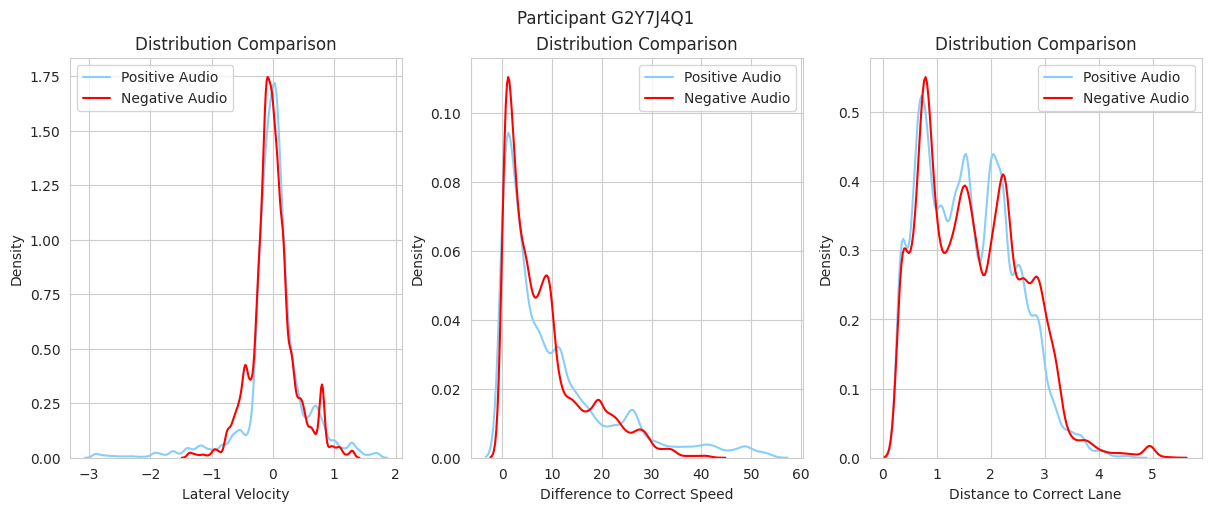

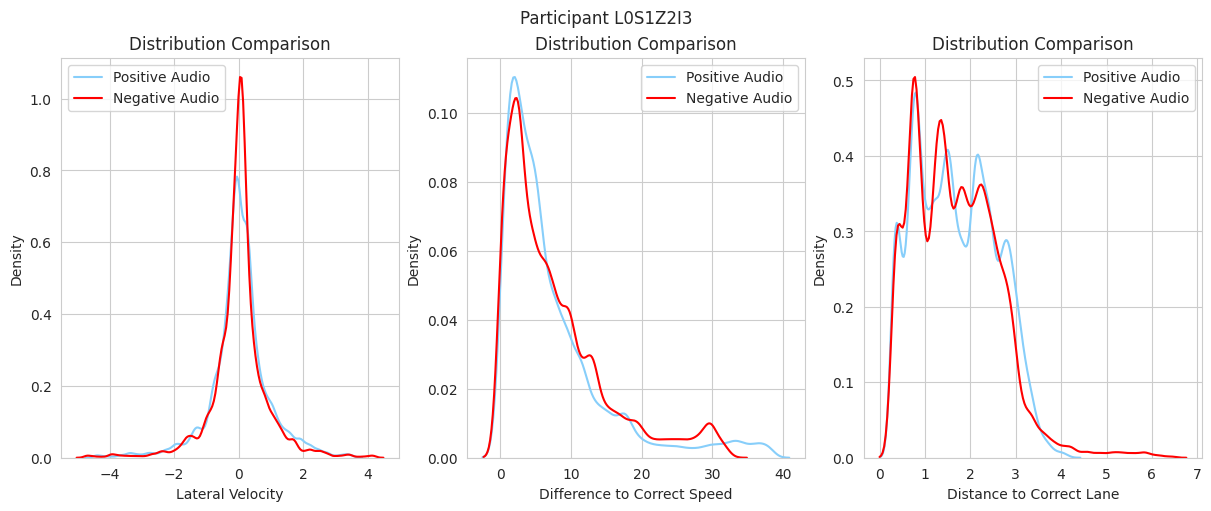

In [39]:
import os


for root, dirs, files in os.walk(data_path):
    identifiers = [f.replace('.csv','') for f in files if f != "W1D9N0B8.csv" and f != 'M3A2H7Q4.csv']

intense_stats = []
calm_stats = []
for id in identifiers:
    load_state_data = False

    data = pd.read_csv(f'{data_path}{id}.csv', comment='#')
    if load_state_data:
        state_data = pd.read_csv(f'data/3d_eye_states_{participant_code}.csv', comment='#')
    else:
        state_data = None

    with open(f'{data_path}{id}.csv', 'r+') as f:
        for line in f.readlines():
            if line.startswith('#Recording time'):
                timestamp_str = line.replace('#Recording time,Date: ', '')
                timestamp_str = timestamp_str[:timestamp_str.find(',Unix time:')]
                break

    try:
        ts = pd.to_datetime(timestamp_str, format="%d.%m.%Y,Time: %H:%M:%S.%f +02:00")
    except:
        ts = pd.to_datetime(timestamp_str, format="%m/%d/%Y,Time: %H:%M:%S.%f +02:00")
    ts = ts - timedelta(hours=2)

    nanoseconds = int(ts.value)
    interpolated_data = data.interpolate('pad')
    try:
        trimmed_data = interpolated_data[['Timestamp', 'Channel 13 (Raw)','Channel 9 (Raw)', 'MarkerName','MarkerDescription','MarkerType', 'DistanceToNextSpeedSign', 'DistanceToNextOverheadSign', 'VelocityX', 'DistanceToTargetPosition',
                'DistanceToTargetSpeed', 'CarSpeed', 'ET_PupilLeft', 'ET_PupilRight']]
    except:
        try:
            trimmed_data = interpolated_data[['Timestamp', 'Channel 13 (ECG100C)','Channel 9 (EDA100C)', 'MarkerName','MarkerDescription','MarkerType', 'DistanceToNextSpeedSign', 'DistanceToNextOverheadSign', 'VelocityX', 'DistanceToTargetPosition',
                'DistanceToTargetSpeed', 'CarSpeed', 'ET_PupilLeft', 'ET_PupilRight']]
        except:
            continue
    
    before_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='Experiment') & (trimmed_data['MarkerType']=='S')].iloc[0]
    before_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='Experiment') & (trimmed_data['MarkerType']=='S')].iloc[-1]

    calm_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='CalmAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
    calm_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='CalmAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

    interim_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='InterimAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
    interim_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='InterimAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

    intense_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
    intense_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]




    calmFirst = calm_audio_start['Timestamp'] < intense_audio_end['Timestamp']

    if calmFirst:
        after_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (
            trimmed_data['MarkerName'] == 'IntenseAudio') &
                                        (trimmed_data['MarkerType'] == 'E')].iloc[0]
        after_audio_end = trimmed_data[trimmed_data['MarkerName'].notna()
                                        & (trimmed_data['MarkerName'] == 'Experiment')
                                        & (trimmed_data['MarkerType'] == 'E')].iloc[0]
    else:
        after_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (
            trimmed_data['MarkerName'] == 'CalmAudio') &
                                        (trimmed_data['MarkerType'] == 'E')].iloc[0]
        after_audio_end = trimmed_data[trimmed_data['MarkerName'].notna()
                                        & (trimmed_data['MarkerName'] == 'Experiment')
                                        & (trimmed_data['MarkerType'] == 'E')].iloc[0]

    before_range = np.arange(before_audio_start['Timestamp'], before_audio_end['Timestamp'])
    calm_range = np.arange(calm_audio_start['Timestamp'], calm_audio_end['Timestamp'])
    interim_range = np.arange(interim_audio_start['Timestamp'],interim_audio_end['Timestamp'])
    intense_range = np.arange(intense_audio_start['Timestamp'], intense_audio_end['Timestamp'])
    after_range = np.arange(after_audio_start['Timestamp'], after_audio_end['Timestamp'])
    total_range = np.arange(before_audio_start['Timestamp'],after_audio_end['Timestamp'])
     
    trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
    trimmed_data['DistanceToTargetPositionStd'] = trimmed_data['DistanceToTargetPosition'].rolling(window=10000).std()
    trimmed_data['DistanceToTargetSpeed_Mean'] = trimmed_data['DistanceToTargetSpeed'].rolling(window=10000).mean()
    trimmed_data['VelocityX_Mean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
    pairs = [
    ('VelocityX', 'Lateral Velocity'),
    ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
    ('DistanceToTargetPosition','Distance to Correct Lane')
    ]

    # Create a figure with enough subplots (3 rows, 1 column here)
    fig, axes = plt.subplots(1, len(pairs), figsize=(4*len(pairs), 5), constrained_layout=True)

    # If only one subplot, axes is not a list, so make it a list for uniformity:
    if len(pairs) == 1:
        axes = [axes]

    for ax, (col1, col2) in zip(axes, pairs):
        statistical_tests(trimmed_data, col1, col2, ax=ax)
        mean1, std1, mom1, mean2, std2, mom2 = get_statistics(trimmed_data, col1, col2)
        # if calmFirst:
        calm_stats.append((mean1, std1, mom1))
        intense_stats.append((mean2, std2, mom2))
        # else:
        #     calm_stats.append((mean2, std2, mom2))
        #     intense_stats.append((mean1, std1, mom1))
        
        

    plt.suptitle(f'Participant {id}')
    plt.savefig(f'Participant {id}.png',dpi=300)
    # plt.show()


In [35]:
velocity_x_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % 3 == 0]
speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % 3 == 1]
position_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % 3 == 2]
velocity_x_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % 3 == 0]
speed_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % 3 == 1]
position_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % 3 == 2]

/tmp/ipykernel_15535/3410394977.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


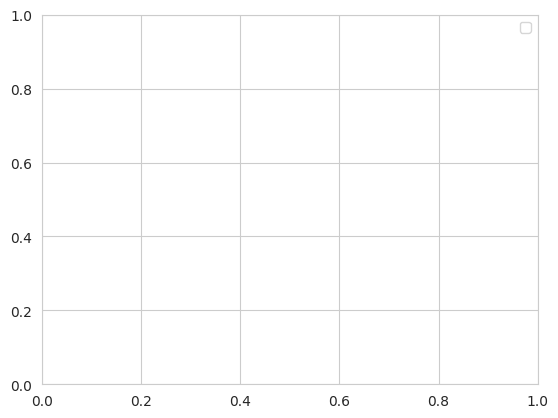

In [36]:
sns.kdeplot([x for x,_,_ in velocity_x_intense], label='Intense Velocity X')
sns.kdeplot([x for x,_,_ in velocity_x_calm], label='Calm Velocity X')
plt.legend()

Text(0.5, 1.0, 'Mean Distance to Target Position')

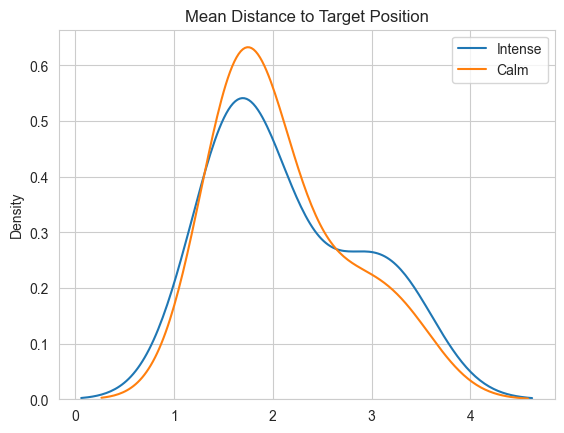

In [ ]:
sns.kdeplot([x for x,_,_ in position_intense], label='Intense')
sns.kdeplot([x for x,_,_ in position_calm], label='Calm')
plt.legend()
plt.title('Mean Distance to Target Position')

Text(0.5, 1.0, 'STD Distance to Target Position')

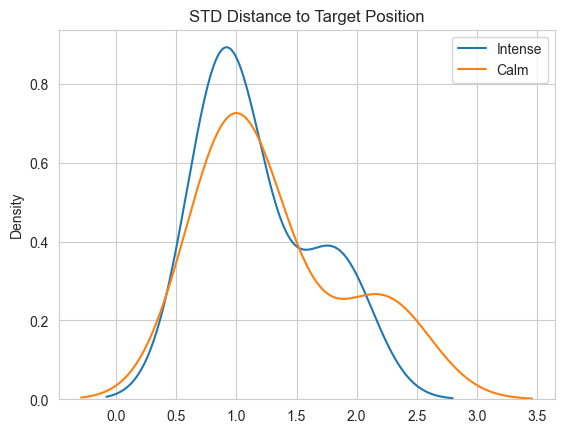

In [ ]:
sns.kdeplot([x for _,x,_ in position_intense if x < 10], label='Intense')
sns.kdeplot([x for _,x,_ in position_calm if x < 10], label='Calm')
plt.legend()
plt.title('STD Distance to Target Position')

Text(0.5, 1.0, 'Mom3 Distance to Target Position')

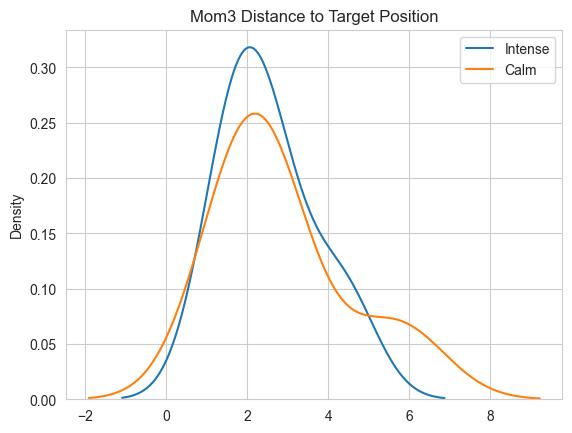

In [ ]:
sns.kdeplot([x for _,_,x in position_intense if x < 10], label='Intense')
sns.kdeplot([x for _,_,x in position_calm if x < 10], label='Calm')
plt.legend()
plt.title('Mom3 Distance to Target Position')

Text(0.5, 1.0, 'Distance to Target Lane Means')

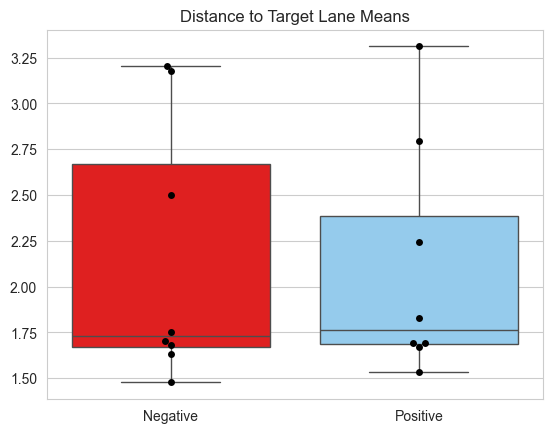

In [ ]:
sns.boxplot({'Negative':[x for x,_,_ in position_intense],'Positive':[x for x,_,_ in position_calm]}, palette=['red', 'lightskyblue'])
sns.swarmplot({'Negative':[x for x,_,_ in position_intense],'Positive':[x for x,_,_ in position_calm]}, color='black')
# sns.kdeplot([x for x,_,_ in position_calm], label='Calm Velocity X')
# plt.legend()
plt.title('Distance to Target Lane Means')

Text(0.5, 1.0, 'Distance to Target Lane STDs')

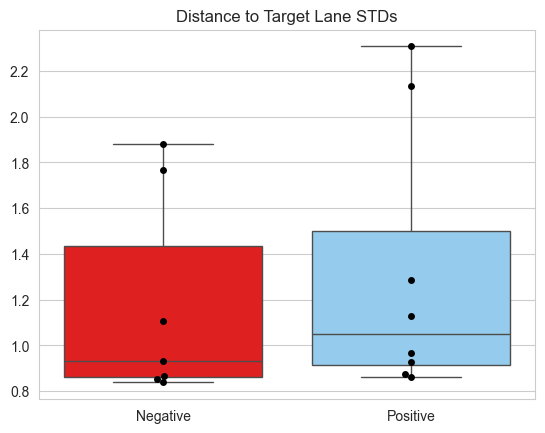

In [ ]:
sns.boxplot({'Negative':[x for _,x,_ in position_intense if x < 10],'Positive':[x for _,x,_ in position_calm if x < 10]}, palette=['red', 'lightskyblue'])
sns.swarmplot({'Negative':[x for _,x,_ in position_intense if x < 10],'Positive':[x for _,x,_ in position_calm if x < 10]}, color='black')
# sns.kdeplot([x for x,_,_ in position_calm], label='Calm Velocity X')
# plt.legend()
plt.title('Distance to Target Lane STDs')

Text(0.5, 1.0, 'Distance To Target Position MOM3')

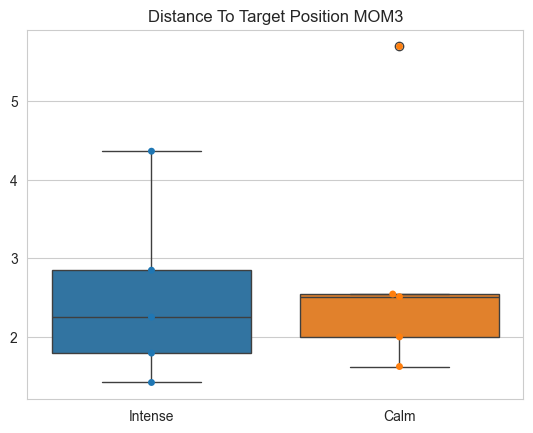

In [ ]:
sns.boxplot({'Intense':[x for _,_,x in position_intense if x < 10],'Calm':[x for _,_,x in position_calm if x < 10]})
sns.swarmplot({'Intense':[x for _,_,x in position_intense if x < 10],'Calm':[x for _,_,x in position_calm if x < 10]})
# sns.kdeplot([x for x,_,_ in position_calm], label='Calm Velocity X')
# plt.legend()
plt.title('Distance To Target Position MOM3')

In [ ]:
print(ttest_rel([x for x,_,_ in position_intense],[x for x,_,_ in position_calm]))
# print(ttest_rel([x for _,x,_ in position_intense if x == 1.2882833289797078],[x for _,x,_ in position_calm if x < 10]))
print(ttest_rel([x for _,_,x in position_intense if x < 10],[x for _,_,x in position_calm if x < 10]))
# [x for _,_,x in position_intense if x < 10]

TtestResult(statistic=np.float64(0.34357447073111924), pvalue=np.float64(0.741254800470919), df=np.int64(7))
TtestResult(statistic=np.float64(-0.37949294707393116), pvalue=np.float64(0.7236089301151356), df=np.int64(4))


Text(0.5, 1.0, 'Distance from Target Speed Means')

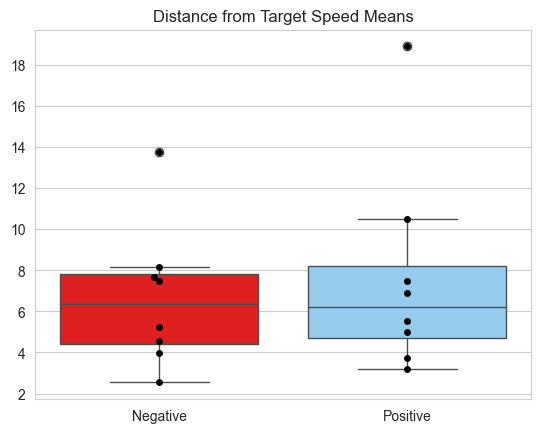

In [ ]:
sns.boxplot({'Negative':[x for x,_,_ in speed_intense],'Positive':[x for x,_,_ in speed_calm]}, palette=['red', 'lightskyblue'])
sns.swarmplot({'Negative':[x for x,_,_ in speed_intense],'Positive':[x for x,_,_ in speed_calm]}, color='black')
# sns.kdeplot([x for x,_,_ in position_calm], label='Calm Velocity X')
# plt.legend()
plt.title('Distance from Target Speed Means')